# Example-01: REM

In [1]:
# In this example basic Reverse Error Method (REM) chaos indicator usage is illustrated

# Given forward and inverse symplectic mappings with signatures R^2n x ... -> R^2n
# First, a given number of iterations is performed using the forward mapping
# Optinaly, a small perturbation can be added after forward iterations
# The same number of iterations are performed using the inverse mapping
# Without round-off errors, one would expect the final state to coinside with the initial one
# However, due to round-off errors there will be some return error
# For chaotic initials this error will be greatly amplified
# Thus, a chaos indicator can be constructed using the above procedure

# Here, a simple 2D symplectic mapping is used to illustrate the REM indicator computation
# Performance optimizations are also discussed (JIT compilation and mapping over a batch of initials)

In [2]:
# Import

import numpy

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward2D
from tohubohu.util import inverse2D

# REM factory

from tohubohu import rem

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", False)

In [4]:
# Set device

device, *_ = jax.devices('gpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set REM indicator

fn = rem(2**12, forward2D, inverse2D)

In [6]:
# Compute indicator for a given inital condition and parameters
# Note, here initial condition is chosen to be close to an elliptic fixed point in the origin and is regular
# The return error is very small (close to a round-off error)

x = jax.numpy.array([0.01, 0.00])
k = jax.numpy.array([0.47, 0.00])

print(jax.numpy.log10(fn(x, k)))

-8.018446


In [7]:
# Now compute indicator for a chaotic initial
# In this case, the return error is more then 10 orders higher

x = jax.numpy.array([0.59, 0.31])
k = jax.numpy.array([0.47, 0.00])

print(jax.numpy.log10(fn(x, k)))

-0.16534849


In [8]:
# REM factory returns a JAX composable function
# It can be JIT compiled to improve performance

# A set of initials can be mapped over the compiled function
# It is also possible to JIT the mapped indicator
# This should be done if one is interested in parametric dependence, e.g. for optimization

# Note, in the following, compilation time is ignored

In [9]:
# Timing (uncompiled)

fn = rem(2**12, forward2D, inverse2D)

x = jax.numpy.array([0.59, 0.31])
k = jax.numpy.array([0.47, 0.00])

fn(x, k) ;

In [10]:
%%timeit
fn(x, k).block_until_ready()

118 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# Timing (compiled)

fn = jit(rem(2**12, forward2D, inverse2D))

x = jax.numpy.array([0.59, 0.31])
k = jax.numpy.array([0.47, 0.00])

fn(x, k) ;

In [12]:
%%timeit
fn(x, k).block_until_ready()

34.6 ms ± 24.6 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
# Set initial grid

n = 1001

qs = jax.numpy.linspace(-0.75, 1.0, n)
ps = jax.numpy.linspace(-0.75, 1.0, n)
xs = jax.numpy.stack(jax.numpy.meshgrid(qs, ps, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
xs.shape

(1002001, 2)

In [14]:
# Indicator (uncompiled)

fn = rem(2**12, forward2D, inverse2D)

x = jax.numpy.array([0.00, 0.00])
k = jax.numpy.array([0.47, 0.00])

fn(x, k) ;

In [15]:
%%time

# Map indicator over a grid

out = vmap(fn, (0, None))(xs, k).block_until_ready()

CPU times: user 655 ms, sys: 489 ms, total: 1.14 s
Wall time: 1.18 s


In [16]:
# Winsorize data

data = numpy.log10(1.0E-16 + numpy.array(out.tolist()))
data[data < -9.0] = -9.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

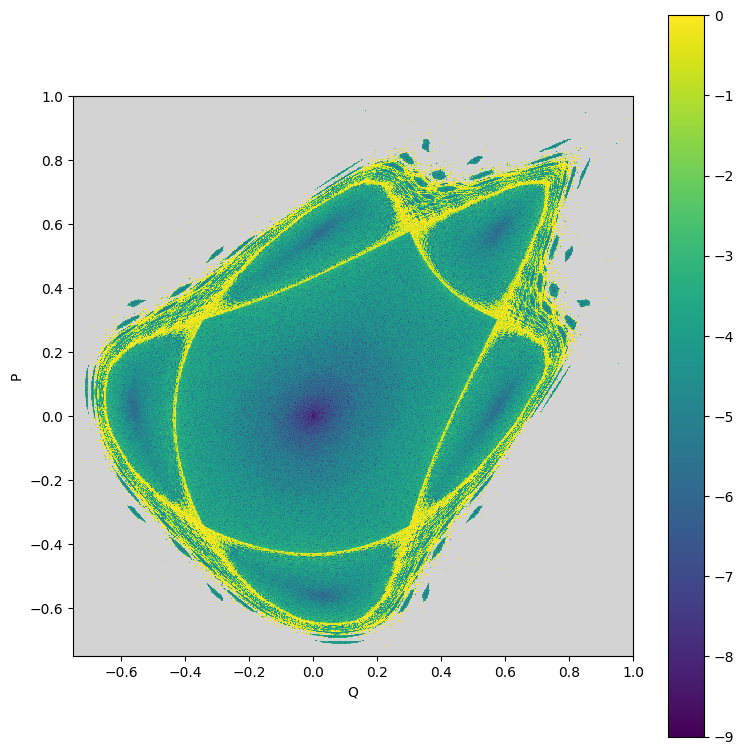

In [17]:
# Plot result

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-9.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

In [18]:
# Indicator (compiled)

fn = jit(rem(2**12, forward2D, inverse2D))

x = jax.numpy.array([0.00, 0.00])
k = jax.numpy.array([0.47, 0.00])

fn(x, k) ;

In [19]:
%%time

# Map indicator over a grid

out = vmap(fn, (0, None))(xs, k).block_until_ready()

CPU times: user 613 ms, sys: 480 ms, total: 1.09 s
Wall time: 1.12 s


In [20]:
# Winsorize data

data = numpy.log10(1.0E-16 + numpy.array(out.tolist()))
data[data < -9.0] = -9.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

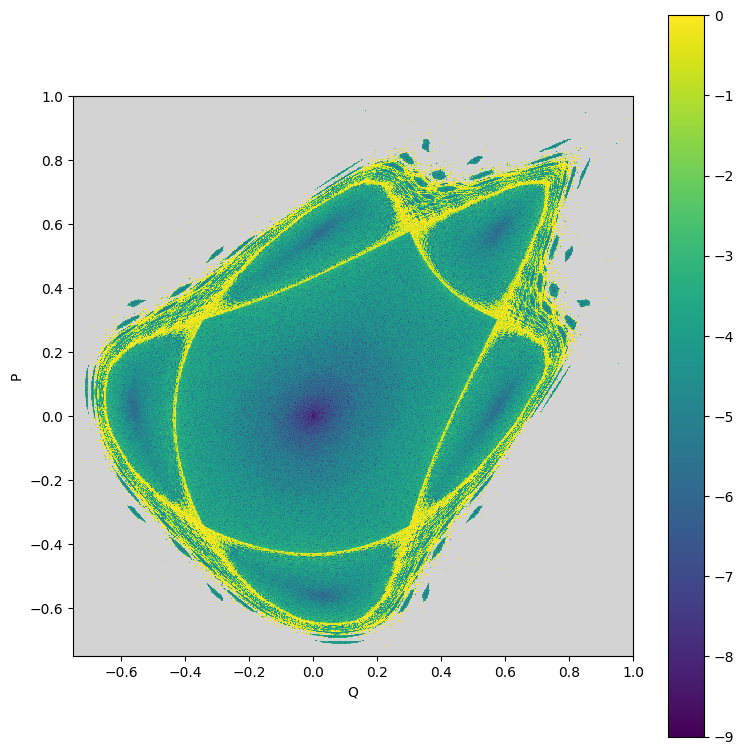

In [21]:
# Plot result

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-9.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

In [22]:
%%time

# Indicator (mapped)

fn = jit(vmap(rem(2**12, forward2D, inverse2D), (0, None)))

out = fn(xs, k).block_until_ready()

CPU times: user 609 ms, sys: 486 ms, total: 1.09 s
Wall time: 1.13 s


In [23]:
# Winsorize data

data = numpy.log10(1.0E-16 + numpy.array(out.tolist()))
data[data < -9.0] = -9.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

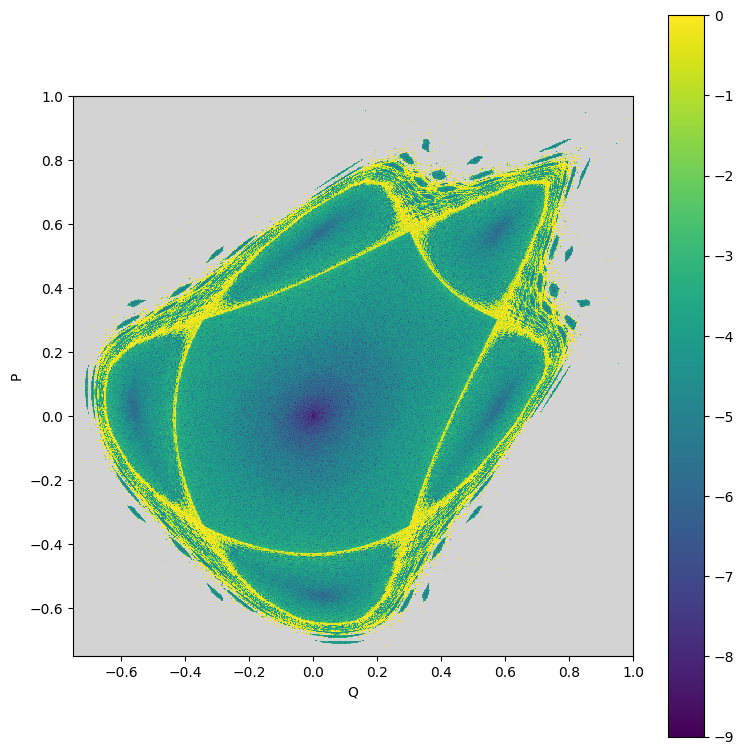

In [24]:
# Plot result

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-9.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

In [25]:
%%time

# Evaluate using different parametes

out = fn(xs, 0.5*k).block_until_ready()

CPU times: user 576 ms, sys: 467 ms, total: 1.04 s
Wall time: 1.08 s


In [26]:
# Winsorize data

data = numpy.log10(1.0E-16 + numpy.array(out.tolist()))
data[data < -9.0] = -9.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

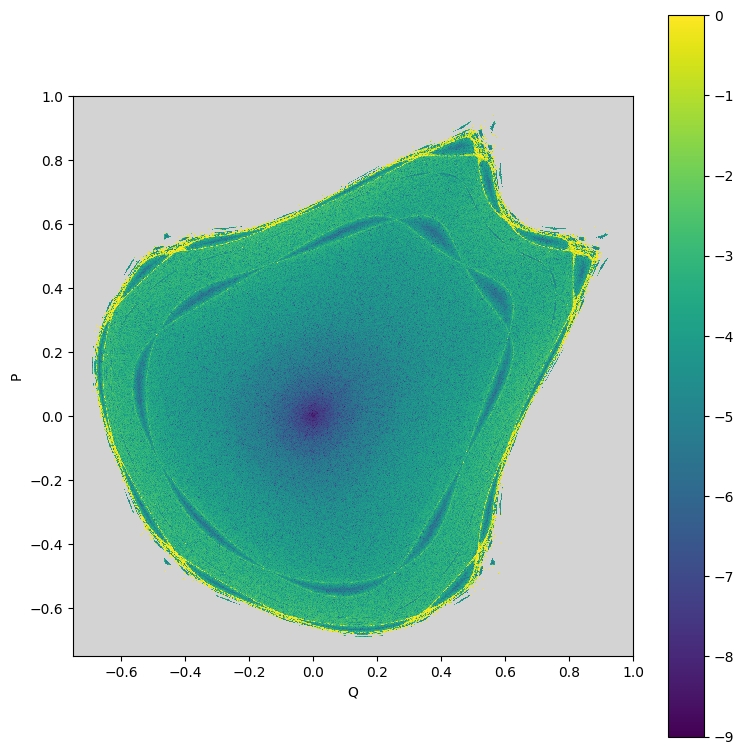

In [27]:
# Plot result

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-9.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()